<a href="https://colab.research.google.com/github/KhanilReddy/ML1/blob/main/Qualcomm_DL_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Prashant-AV/Qualcomm-DL-Hackathon.git

Cloning into 'Qualcomm-DL-Hackathon'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 30.68 MiB | 27.65 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [23]:
import zipfile
import os
import shutil

def extract_all_files(zip_dir, output_dir):
    """
        This function is used to extract all the images from images part-1.zip and images part-2.zip to all_images folder
    """
    if os.path.exists(zip_dir):
      # Get the zip files in train directory
      files = os.listdir(zip_dir)
      zip_files = [f for f in files if f.endswith('.zip')]

      if not os.path.exists(output_dir):
        os.mkdir(output_dir)

      # Extract each zip file
      for zip_file in zip_files:
          with zipfile.ZipFile(os.path.join(zip_dir, zip_file), 'r') as zip_ref:
              for member in zip_ref.namelist():
                  # Extract each file to the all_images directory without creating subfolders
                  filename = os.path.basename(member)
                  if filename:
                      source = zip_ref.open(member)
                      target = open(os.path.join(output_dir, filename), "wb")
                      with source, target:
                          shutil.copyfileobj(source, target)
    else:
      print("f{zip_dir} doesn't exits")

In [24]:
# Define the directory containing the zip files and the all_images directory
train_directory = '/content/Qualcomm-DL-Hackathon/train/'
all_images_directory = os.path.join(train_directory , 'all_images')

# Extract all files from the zip files to the all_images directory
extract_all_files(train_directory, all_images_directory)

print(f"All files have been extracted to {all_images_directory}.")

All files have been extracted to /content/Qualcomm-DL-Hackathon/train/all_images.


In [25]:
!ls '/content/Qualcomm-DL-Hackathon/train/all_images' | wc -l

2352


In [22]:
#!rm -r "/content/Qualcomm-DL-Hackathon/train/all_images"

In [26]:
import pandas as pd

# Get the image names and labels from the train CSV file
train_csv = os.path.join(train_directory , 'train.csv')
data = pd.read_csv(train_csv)
image_names, labels = data['image_names'].tolist(), data['emergency_or_not'].tolist()

# move all the train images to corresponding folder based on label in train.csv
train_images = os.path.join(train_directory , 'train_images')
non_emergency_images = os.path.join(train_images , '0')
emergency_images = os.path.join(train_images , '1')

if not os.path.exists(train_images):
    os.makedirs(train_images)
if not os.path.exists(emergency_images):
    os.makedirs(emergency_images)
if not os.path.exists(non_emergency_images):
    os.makedirs(non_emergency_images)

for image in image_names:
  source = os.path.join(all_images_directory, image)
  if labels[image_names.index(image)] == 1:
    shutil.move(source, os.path.join(emergency_images, image))
  else:
    shutil.move(source, os.path.join(non_emergency_images, image))

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
from PIL import Image

# Define transformations for the training datasets
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
])

# Load datasets and Create DataLoaders
train_dataset = datasets.ImageFolder(root=train_images, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [43]:
# Architecture of the model
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Flatten(),
    nn.Linear(128 * 16 * 16, 512),
    nn.ReLU(),
    nn.Linear(512, 64) ,
    nn.ReLU(),
    nn.Linear(64, 1)
)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [45]:
# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in train_loader:

        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Convert logits to binary predictions
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.float().unsqueeze(1)).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch [1/10], Loss: 0.4741, Accuracy: 77.70%
Epoch [2/10], Loss: 0.4438, Accuracy: 78.49%
Epoch [3/10], Loss: 0.3814, Accuracy: 82.44%
Epoch [4/10], Loss: 0.2920, Accuracy: 86.63%
Epoch [5/10], Loss: 0.2263, Accuracy: 90.16%
Epoch [6/10], Loss: 0.1717, Accuracy: 92.65%
Epoch [7/10], Loss: 0.1042, Accuracy: 95.87%
Epoch [8/10], Loss: 0.0908, Accuracy: 96.17%
Epoch [9/10], Loss: 0.0759, Accuracy: 97.21%
Epoch [10/10], Loss: 0.0257, Accuracy: 99.27%


In [46]:
test_images = os.path.join(train_directory , 'test_images')
if not os.path.exists(test_images):
    os.makedirs(test_images)

# Load the Test CSV file
test_csv = "/content/Qualcomm-DL-Hackathon/test.csv"
data = pd.read_csv(test_csv)
test_image_names = data['image_names'].tolist()
print(test_image_names)

for image in test_image_names:
  shutil.move(os.path.join(all_images_directory, image), os.path.join(test_images, image))

['1960.jpg', '668.jpg', '2082.jpg', '808.jpg', '1907.jpg', '350.jpg', '1557.jpg', '111.jpg', '1952.jpg', '1466.jpg', '2071.jpg', '1891.jpg', '1900.jpg', '1927.jpg', '1414.jpg', '134.jpg', '1037.jpg', '56.jpg', '208.jpg', '629.jpg', '979.jpg', '2099.jpg', '332.jpg', '1814.jpg', '1094.jpg', '1886.jpg', '342.jpg', '2134.jpg', '1465.jpg', '482.jpg', '229.jpg', '1078.jpg', '611.jpg', '1349.jpg', '1805.jpg', '1947.jpg', '299.jpg', '463.jpg', '2154.jpg', '1244.jpg', '581.jpg', '218.jpg', '1553.jpg', '1025.jpg', '1591.jpg', '1132.jpg', '2117.jpg', '1795.jpg', '2254.jpg', '1950.jpg', '507.jpg', '445.jpg', '1501.jpg', '2349.jpg', '678.jpg', '1604.jpg', '792.jpg', '879.jpg', '1779.jpg', '2156.jpg', '44.jpg', '686.jpg', '1311.jpg', '2192.jpg', '440.jpg', '1047.jpg', '254.jpg', '479.jpg', '282.jpg', '2339.jpg', '2066.jpg', '1379.jpg', '759.jpg', '2262.jpg', '672.jpg', '2036.jpg', '279.jpg', '596.jpg', '486.jpg', '651.jpg', '1138.jpg', '881.jpg', '433.jpg', '1640.jpg', '1293.jpg', '2140.jpg', '2097.

In [49]:
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def eval_image(test_image_name):
  image_path = os.path.join(test_images, test_image_name)
  image = Image.open(image_path)
  image = test_transforms(image).unsqueeze(0)  # Apply transformations and add batch dimension
  # Evaluate on the test set
  model.eval()
  with torch.no_grad():
      outputs = model(image).squeeze()
      predicted = (outputs > 0.5).int()
  return predicted.item()

In [50]:

data['emergency_or_not'] = None
for index, row in data.iterrows():
    image_name = row['image_names']
    data.at[index, 'emergency_or_not'] = eval_image(image_name)
print(data.head())
data.to_csv(test_csv, index=False)

  image_names emergency_or_not
0    1960.jpg                0
1     668.jpg                1
2    2082.jpg                0
3     808.jpg                1
4    1907.jpg                0


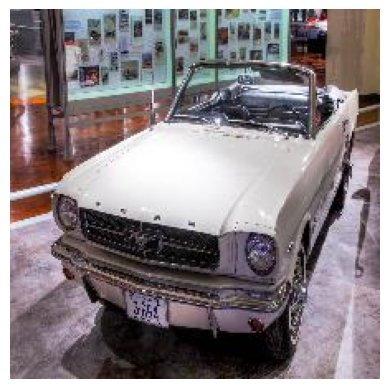

In [52]:
import matplotlib.pyplot as plt
# Display the image with prediction
plt.imshow(Image.open(os.path.join(test_images, '1960.jpg')))
plt.axis("off")
plt.show()